In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import matplotlib
import scipy
from segmentation_models_pytorch import utils as smp_utils
import pandas as pd
from os.path import exists
from natsort import natsorted

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
DATA_DIR = './'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'train')
y_valid_dir = os.path.join(DATA_DIR, 'train_annot')

x_test_dir = os.path.join(DATA_DIR, 'train')
y_test_dir = os.path.join(DATA_DIR, 'train_annot')

In [5]:
# helper function for data visualization
def visualize(image, mask):
    """PLot images in one row."""
    n = mask.shape[2]+1
    plt.figure(figsize=(n*6, 5))
    # for i, (name, image) in enumerate(images.items()):

    plt.subplot(1, n, 1)
    plt.xticks([])
    plt.yticks([])
    # plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
    
    cmaps = [
        matplotlib.colors.ListedColormap(['black', 'red']),
        matplotlib.colors.ListedColormap(['black', 'orange']),
        matplotlib.colors.ListedColormap(['black', 'blue']),
        matplotlib.colors.ListedColormap(['black', 'pink']),
        matplotlib.colors.ListedColormap(['black', 'green']),
        matplotlib.colors.ListedColormap(['black', 'yellow']),
        matplotlib.colors.ListedColormap(['black', 'red']),
    ]
    names = ['C', 'Ca', 'Mg', 'Na', 'O', 'S', 'Cl']
    
    for j in range(7):
        plt.subplot(1, n, j + 2)
        plt.xticks([])
        plt.yticks([])
        name = names[j]
        plt.title(name)
        plt.imshow(mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
    plt.show()

In [6]:
class Dataset(BaseDataset):
    """Setup Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        # list file names in the self.ids list
        self.sem_ids = os.listdir(images_dir)
        self.label_ids = os.listdir(masks_dir)
        
        self.sem_ids.sort()
        self.label_ids.sort()
        
        if self.sem_ids[0].startswith('.'):
            self.sem_ids.pop(0)
            
        if self.label_ids[0].startswith('.'):
            self.label_ids.pop(0)
        
        self.sem_ids = natsorted(self.sem_ids)
        self.label_ids = natsorted(self.label_ids)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.sem_ids]
        self.masks_fps = [os.path.join(masks_dir, label_id) for label_id in self.label_ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # print(image.shape)
        # converting the file dimension in [N, C, H, W] order
        # image = np.transpose(image, (2, 0, 1))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat = scipy.io.loadmat(self.masks_fps[i])
        mask = mat['label']
        mask = np.transpose(mask, (1, 2, 0))
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.sem_ids)

In [7]:
def get_training_augmentation():
    
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [8]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        # albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
torch.cuda.empty_cache()
# torch.cuda.set_per_process_memory_fraction(0.9, 0)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [10]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [12]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [13]:
cmaps = [
    matplotlib.colors.ListedColormap(['black', 'red']),
    matplotlib.colors.ListedColormap(['black', 'orange']),
    matplotlib.colors.ListedColormap(['black', 'blue']),
    matplotlib.colors.ListedColormap(['black', 'pink']),
    matplotlib.colors.ListedColormap(['black', 'green']),
    matplotlib.colors.ListedColormap(['black', 'yellow']),
    matplotlib.colors.ListedColormap(['black', 'red']),
]
names = ['C', 'Ca', 'Mg', 'Na', 'O', 'S', 'Cl']

In [14]:
for i in range(607, 608):
    # i = np.random.choice(len(test_dataset))
    image, gt_mask = test_dataset[i]
    
    image_vis = np.transpose(image, (1, 2, 0))
    image_vis = image_vis.astype('uint8')
    
    gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    x_tensor = x_tensor.float()

    best_model = torch.load('./best_model.pth')
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
    pr_mask = np.transpose(pr_mask, (1, 2, 0)) # (1920, 2560, 7)
    
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    for j in range(7):
        
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pr_mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
        plt.savefig('EDS_output/' + str(i+1) + '_' + names[j] + '_pr' + '.png', bbox_inches='tight',transparent=True, pad_inches=0)
        plt.close()
        
        plt.xticks([])
        plt.yticks([])
        plt.imshow(gt_mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
        plt.savefig('EDS_output/' + str(i+1) + '_' + names[j] + '_gt' + '.png', bbox_inches='tight',transparent=True, pad_inches=0)
        plt.close()
        

    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    # visualize(
    #     image=image_vis,
    #     mask=gt_mask,
    # )
    # visualize(
    #     image=image_vis, 
    #     mask=pr_mask
    # )

In [15]:
import shutil
shutil.make_archive('EDS_output', 'zip', 'EDS_output')

'/home/ubuntu/Method-optimization/Model/EDS_output.zip'

(3, 1920, 2560)


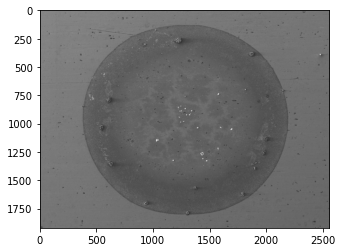

In [16]:
print(image.shape)
image = np.transpose(image, (1, 2, 0))
image = image.astype(int)
plt.imshow(image)